## Modules

In [1]:
import os
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
from datetime import datetime, timedelta
from itertools import product

## Binary outcome & simulation: Arithmetic betting & risk-of-ruin

### Binary game simulation function

In [2]:
def getSim_binaryFixAmount(initAmount=100, a=12.5, p=0.5, b=1.5, numTrials=50, numSim=400):
    """
    Obtain dictionary of equal-amount-bet simulation results.
    initAmount: initial amount for betting
    f: percent per bet
    p: winning probability
    b: reward-to-risk ratio (/ odds)
    numTrialss: number of trials of the same binary game
    numSim: number of binary simulations
    """
    # Dict for recording different series of profit/loss
    simDict = {}
    # Dict for recording different series of capital (total equity)
    amountDict = {}
    # Generate a total of `numSim`= N series of binary game result and P/L
    stepFunc = lambda x: 1 if x > 0 else 0  # Lambda Function for getting "1" with a fixed prob and "0" otherwise
    for num in range(numSim):
        # Generate a series of "1"/"0" with probability p
        signArray = np.array([stepFunc(r) for r in np.random.uniform(p - 1, p, numTrials)])
        # Series of asset increment on win/loss result (EITHER increase by a * b OR decrease by a)
        trialArray = a * ((b + 1) * signArray - 1)
        # Record the asset increment series into `simDict`
        simDict[num + 1] = trialArray
        # Array of total equity and record into `amountDict`
        amountArray = initAmount + trialArray.cumsum()
        # IF equity drops below the fixed bet amount, stop betting
        period = 1
        while period <= numTrials - 1:
            if amountArray[period] < a:
                for j in range(period, numTrials):
                    amountArray[j] = amountArray[period]
                amountDict[f's{num}'] = amountArray
                break
            period += 1
        amountDict[f's{num + 1}'] = amountArray
    # Form dataframe from the `amountDict` and transpose, so that each row corresponds to a betting series
    dfSim = pd.DataFrame(amountDict).transpose()
    # Rename columns so that each number in column labels corresponds to the k-th trial
    dfSim = dfSim.rename(columns={k: (k + 1) for k in dfSim.columns})

    return dfSim

### Performance KPIs: winning rate, RRR (Realized reward-risk ratio), profit factor

In [3]:
def getProfitfactor(p, b):
    """Get profit factor of a binary game."""
    return round(p * b / (1 - p), 4)

def getOdds(p, pf):
    """Given fixed winning rate and profit factor, find odds (or reward-risk ratio)."""
    return pf * (1 - p) / p

def getWinrate(b, pf):
    """Given fixed odds and profit factor, find winning rate."""   
    return pf / (pf + b)

### Sample simulation: 20 trials, 30 simulations, converted into dataframe

In [4]:
initAmount0 = 100  # Initial capital
a0 = 20  # Fixed amount per bet
p0 = 0.5   # winning probability
b0 = 1.25   # reward-risk ratio / odds
numTrials0 = 10 # Number of trials
numSim0 = 20  # Number of simulations (how many people keep playing same game for 10 runs)

pf0 = round(getProfitfactor(p0, b0), 4)
print(f'Profit Factor = {pf0}')

dfSim0 = np.round(getSim_binaryFixAmount(initAmount0, a0, p0, b0, numTrials0, numSim0), 2)
dfSim0

Profit Factor = 1.25


,1,2,3,4,5,6,7,8,9,10
s1,80.0,105.0,130.0,155.0,135.0,160.0,185.0,210.0,190.0,215.0
s2,125.0,105.0,85.0,110.0,135.0,115.0,140.0,120.0,100.0,80.0
s3,80.0,60.0,85.0,65.0,90.0,70.0,95.0,75.0,55.0,35.0
s4,125.0,150.0,175.0,155.0,135.0,115.0,95.0,120.0,145.0,170.0
s5,80.0,105.0,85.0,110.0,135.0,115.0,95.0,120.0,145.0,125.0
s6,80.0,105.0,85.0,110.0,90.0,115.0,95.0,75.0,55.0,80.0
s7,125.0,150.0,130.0,110.0,90.0,70.0,50.0,30.0,10.0,10.0
s8,125.0,105.0,85.0,65.0,45.0,25.0,5.0,5.0,5.0,5.0
s9,125.0,105.0,85.0,65.0,45.0,25.0,5.0,5.0,5.0,5.0
s10,125.0,150.0,130.0,110.0,90.0,70.0,95.0,75.0,100.0,125.0


## Equity curve plotting

### Functions for simulation KPI & curve plotting

In [5]:
def getSimKPI_discretePL(simFunc, initAmount=100, f=12.5, p=0.5, b=1.5, numTrials=50, numSim=400):
    """Obtain a dictionary of final performance KPI of simulations. """
    dfSim = simFunc(initAmount, f, p, b, numTrials, numSim)
    dictKPI = {}
    dictKPI['p'] = p
    dictKPI['b'] = b
    dictKPI['f'] = f
    dictKPI['profitfactor'] = round(getProfitfactor(p, b), 4)
    dictKPI['win%'] = round(100 * dfSim[dfSim[numTrials] >= initAmount].shape[0] / numSim, 2)
    dictKPI['avgAmount'] = round(dfSim[numTrials].mean(), 2)
    dictKPI['midAmount'] = round(dfSim[numTrials].median(), 2)
    dictKPI['stdAmount'] = round(dfSim[numTrials].std(), 2)

    return dfSim, dictKPI

def plotSim_discretePL(simFunc, initAmount=100, a=12.5, p=0.5, b=1.5, numTrials=50, numSim=400):
    """Plot equity curves from the betting simulations."""
    # Dataframe and KPI dict from `getSimKPI_discretePL()` function
    dfSim, dictKPI = getSimKPI_discretePL(simFunc, initAmount, a, p, b, numTrials, numSim)
    # First line of diagram title
    title = f'{numSim} simulations of {numTrials}-step binary game \n'
    title += f'Winning rate {round(p, 4)}, odds {round(b, 4)}, ${a} per bet \n'

    # Percentage of final equity above or equal to initial amount
    winrate = dictKPI['win%']
    avgAmount = dictKPI['avgAmount']  # Arithmetic mean of final equity
    midAmount = dictKPI['midAmount']  # Median of final equity
    stdAmount = dictKPI['stdAmount']  # SD of final equity
    profitfactor = dictKPI['profitfactor']

    # Attach key stats to title text
    title += f'Profit factor: {profitfactor}, final winrate: {winrate}% \n'
    title += f'Final equity mean: {avgAmount}, median: {midAmount}, SD: {stdAmount}'

    # Plot figure & append title
    fig = plt.figure(figsize=(12, 9))
    fig.suptitle(title, fontsize=12)

    # Transpose the equity dataframe to plot
    dfPlot = dfSim.transpose()
    plt.plot(dfPlot)
    plt.plot(dfPlot.index, np.repeat(initAmount, numTrials), color='black', linewidth=3, linestyle='dashed')
    plt.show()

### Standard sample: p = 0.4, b = 2.0

In [6]:
initAmount1 = 100  
a1 = 10  
p1 = 0.4   
b1 = 2.0   
numTrials1 = 50 
numSim1 = 1000  

dfSim1, dictKPI1 = getSimKPI_discretePL(getSim_binaryFixAmount, initAmount1, a1, p1, b1, numTrials1, numSim1)
dictKPI1

{'p': 0.4,
 'b': 2.0,
 'f': 10,
 'profitfactor': 1.3333,
 'win%': 75.1,
 'avgAmount': 178.79,
 'midAmount': 170.0,
 'stdAmount': 118.36}

### Curves of 1000 simulations of 50 trials

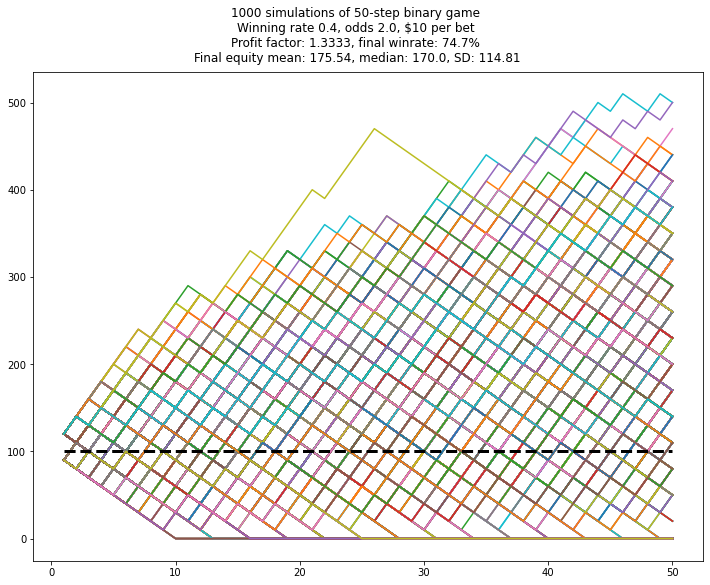

In [7]:
plotSim_discretePL(getSim_binaryFixAmount, initAmount1, a1, p1, b1, numTrials1, numSim1)

### Raising winning rate & fix amount-per-bet, profit factor (odds reduced)

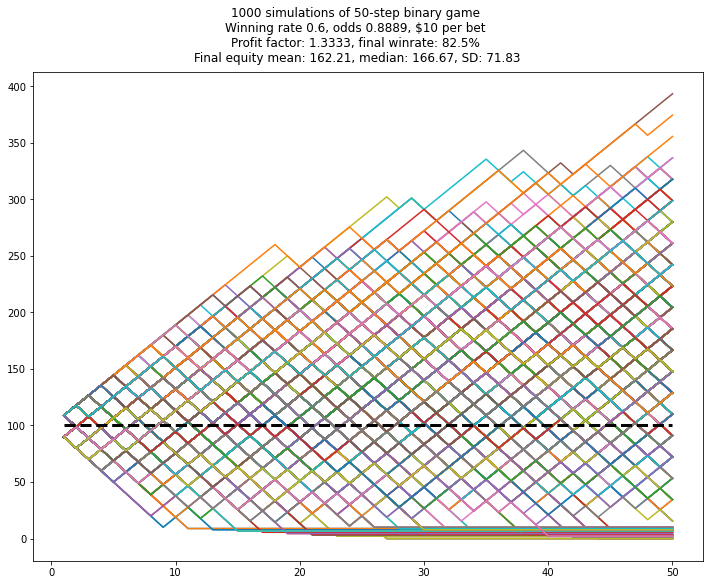

In [8]:
profitfactor1 = 4 / 3
p2 = 0.6   
b2 = getOdds(p2, profitfactor1)

plotSim_discretePL(getSim_binaryFixAmount, initAmount1, a1, p2, b2, numTrials1, numSim1)

### Fix p & b, vary amount-per-bet

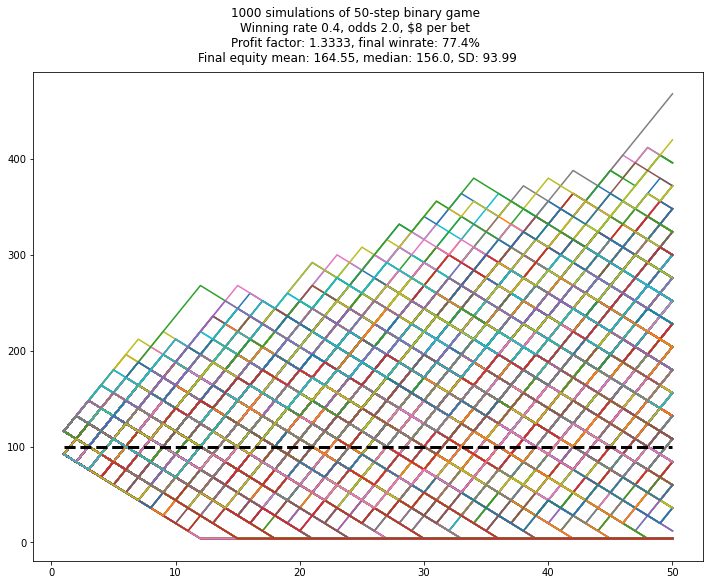

In [9]:
a2 = 8
plotSim_discretePL(getSim_binaryFixAmount, initAmount1, a2, p1, b1, numTrials1, numSim1)

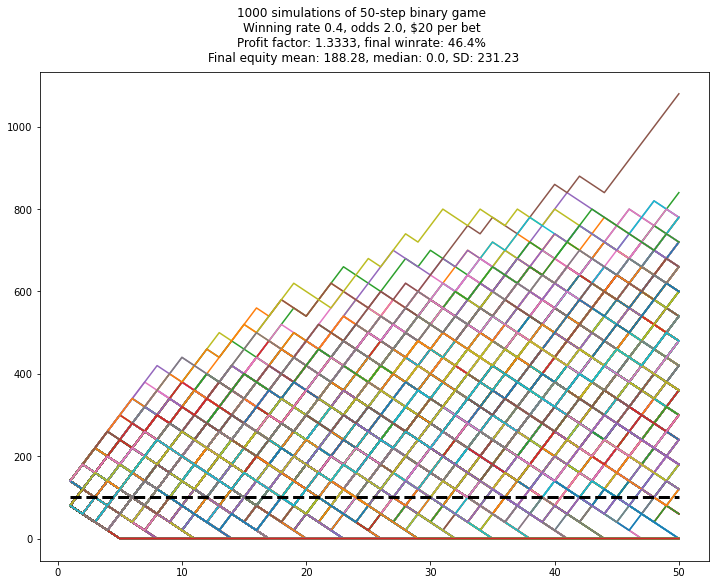

In [10]:
a3 = 20
plotSim_discretePL(getSim_binaryFixAmount, initAmount1, a3, p1, b1, numTrials1, numSim1)

## Risk control & ruin

### Risk of ruin & MDD in a simulation

In [11]:
def getRuin(dfSim, initAmount=100, numTrial=50, level=0.1):
    """Obtain percentage of simulations with final amount dropping below the given equity threshold."""   
    return dfSim[dfSim[numTrial] <= level*initAmount].shape[0] / dfSim.shape[0]

def getSimMDD(dfSim, levelsMDD=(0.2, 0.5, 0.8, 0.9)):
    """Obtain percentage of simulations with final amount dropping below the given equity threshold."""
    # Transpose the simulation dataframe
    dfSimT = dfSim.transpose()
    numTrial = dfSim.shape[1]
    numSim = dfSim.shape[0]
    # Compute MDD
    dfMDD = pd.DataFrame(columns=dfSimT.columns)
    for col in dfSimT.columns:
        dfMDD[col] = (dfSimT[col] / dfSimT[col].cummax() - 1).cummin()
    # Tranpose back to match original shape
    dfMDD = dfMDD.transpose()
    # Compute percentage of simulations having MDD greater than the levels
    dictMDD = {}
    for value in levelsMDD:
        dictMDD[value] = dfMDD[dfMDD[numTrial] <= -value].shape[0] / numSim

    return dfMDD, dictMDD   

### Using above (p, b) pair and vary number of trials

In [12]:
trialsRange = range(50, 300, 50)  ## Number of betting trials from 50 to 250

for numTrials in trialsRange:
    dfSim = getSim_binaryFixAmount(initAmount1, a1, p1, b1, numTrials, 1000)
    ruin = getRuin(dfSim, initAmount1, numTrials, a1 / initAmount1)
    print(f'\n% of betting series with final equity below amount-per-bet ${a1} after {numTrials} trials: {ruin}\n')
    dfMDD, dictMDD = getSimMDD(dfSim)
    print(f'Percentage of betting series suffering \n')
    
    for key, value in dictMDD.items():
        print(f'{round(100*key)}% MDD: {round(100*value, 2)}%')


% of betting series with final equity below amount-per-bet $10 after 50 trials: 0.17782217782217782

Percentage of betting series suffering 

20% MDD: 93.41%
50% MDD: 48.55%
80% MDD: 23.18%
90% MDD: 19.48%

% of betting series with final equity below amount-per-bet $10 after 100 trials: 0.24675324675324675

Percentage of betting series suffering 

20% MDD: 97.4%
50% MDD: 57.44%
80% MDD: 30.77%
90% MDD: 26.47%

% of betting series with final equity below amount-per-bet $10 after 150 trials: 0.286

Percentage of betting series suffering 

20% MDD: 97.2%
50% MDD: 59.8%
80% MDD: 35.8%
90% MDD: 30.9%

% of betting series with final equity below amount-per-bet $10 after 200 trials: 0.26073926073926074

Percentage of betting series suffering 

20% MDD: 96.7%
50% MDD: 60.94%
80% MDD: 31.87%
90% MDD: 28.37%

% of betting series with final equity below amount-per-bet $10 after 250 trials: 0.249

Percentage of betting series suffering 

20% MDD: 97.4%
50% MDD: 56.5%
80% MDD: 31.3%
90% MDD: 27.5%

### Fix p, b and raise amount-per-bet to 20

In [13]:
for numTrials in trialsRange:
    dfSim = getSim_binaryFixAmount(initAmount1, a3, p1, b1, numTrials, 1000)
    ruin = getRuin(dfSim, initAmount1, numTrials, a3 / initAmount1)
    print(f'\n% of betting series with final equity below amount-per-bet ${a1} after {numTrials} trials: {ruin}\n')
    dfMDD, dictMDD = getSimMDD(dfSim)
    print(f'Percentage of betting series suffering \n')
    
    for key, value in dictMDD.items():
        print(f'{round(100*key)}% MDD: {round(100*value, 2)}%')


% of betting series with final equity below amount-per-bet $10 after 50 trials: 0.555

Percentage of betting series suffering 

20% MDD: 99.1%
50% MDD: 81.3%
80% MDD: 62.4%
90% MDD: 56.9%

% of betting series with final equity below amount-per-bet $10 after 100 trials: 0.5924075924075924

Percentage of betting series suffering 

20% MDD: 99.5%
50% MDD: 85.71%
80% MDD: 65.13%
90% MDD: 60.54%

% of betting series with final equity below amount-per-bet $10 after 150 trials: 0.5664335664335665

Percentage of betting series suffering 

20% MDD: 99.6%
50% MDD: 84.52%
80% MDD: 64.04%
90% MDD: 58.24%

% of betting series with final equity below amount-per-bet $10 after 200 trials: 0.6353646353646354

Percentage of betting series suffering 

20% MDD: 99.6%
50% MDD: 86.31%
80% MDD: 68.23%
90% MDD: 65.13%

% of betting series with final equity below amount-per-bet $10 after 250 trials: 0.607

Percentage of betting series suffering 

20% MDD: 99.4%
50% MDD: 85.0%
80% MDD: 65.6%
90% MDD: 61.6%


## Fixed p = 0.5, 100 bets (2 year), 1000 sims, varied amount-per-bet and odds

### Simulations

In [14]:
bList = [0.25 * r for r in range(2, 13)]
aList = [25, 20, 15, 10, 5, 2]
initAmount = 100
p = 0.5
numTrials = 100
numSim = 1000

simDict1 = {}
dfProb1 = pd.DataFrame()  # Terminal winning probability
dfAvg1 = pd.DataFrame() # Average final P/L
dfStd1 = pd.DataFrame() # SD of final P/L
dfRuin1 = pd.DataFrame()  # Risk of ruin

for b, a in product(bList, aList):
    dfSim, kpiDict = getSimKPI_discretePL(getSim_binaryFixAmount, initAmount, a, p, b, numTrials, numSim)
    simDict1[(p, b, a)] = dfSim
    dfProb1.loc[f'${a}', b] = kpiDict['win%']
    dfAvg1.loc[f'${a}', b] = kpiDict['avgAmount'] - initAmount
    dfStd1.loc[f'${a}', b] = kpiDict['stdAmount'] 
    dfRuin1.loc[f'${a}', b] = getRuin(dfSim, initAmount, numTrials, level=a / initAmount)

### Terminal winning probability

In [15]:
dfProb1[(dfRuin1 < 0.01) & (dfAvg1 > 0)]

,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
$25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.2,99.2,NaN,99.8
$5,NaN,NaN,NaN,85.3,98.5,99.5,100.0,100.0,100.0,100.0,100.0
$2,NaN,NaN,NaN,85.9,97.5,99.7,100.0,100.0,100.0,100.0,100.0


### Average terminal P/L

In [16]:
dfAvg1[(dfRuin1 < 0.01) & (dfAvg1 > 0)]

,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
$25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,625.58,743.35,NaN,1005.72
$5,NaN,NaN,NaN,62.59,124.36,187.80,251.27,312.95,377.90,436.06,498.28
$2,NaN,NaN,NaN,23.89,49.57,75.57,100.25,125.54,150.29,174.65,199.17


### SD of terminal P/L

In [17]:
dfStd1[(dfRuin1 < 0.01) & (dfAvg1 > 0)]

,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
$25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.97,188.65,NaN,205.39
$5,NaN,NaN,NaN,58.00,62.18,72.74,77.28,83.76,89.22,92.09,102.14
$2,NaN,NaN,NaN,22.26,24.95,27.81,30.14,32.87,35.64,36.48,40.69


### Risk-of-ruin

In [18]:
dfRuin1[(dfAvg1 > 0)]

,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
$25,NaN,NaN,NaN,0.707000,0.500000,0.406,0.287000,0.240,0.212787,0.1998,0.182
$20,NaN,NaN,NaN,0.607000,0.416583,0.300,0.164000,0.141,0.131000,0.1210,0.100
$15,NaN,NaN,NaN,0.453000,0.218000,0.158,0.118881,0.059,0.066000,0.0600,0.056
$10,NaN,NaN,NaN,0.237762,0.068000,0.044,0.020000,0.008,0.008000,0.0100,0.002
$5,NaN,NaN,NaN,0.006000,0.000000,0.000,0.000000,0.000,0.000000,0.0000,0.000
$2,NaN,NaN,NaN,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.0000,0.000


## Fixed odds = 1, 100 bets (2 year), 1000 sims, varied amount-per-bet and winning rate

### Simulations

In [19]:
pList = np.arange(0.25, 0.75, 0.05)
aList = [25, 20, 15, 10, 5, 2]

initAmount = 100
b = 1.0
numTrials = 100
numSim = 1000

simDict2 = {}
dfProb2 = pd.DataFrame()  # Terminal winning probability
dfAvg2 = pd.DataFrame() # Average final P/L
dfStd2 = pd.DataFrame() # SD of final P/L
dfRuin2 = pd.DataFrame()  # Risk of ruin

for p, a in product(pList, aList):
    dfSim, kpiDict = getSimKPI_discretePL(getSim_binaryFixAmount, initAmount, a, p, b, numTrials, numSim)
    simDict2[(p, b, a)] = dfSim
    pct = round(100 * p)
    dfProb2.loc[f'${a}', f'{pct}%'] = kpiDict['win%']
    dfAvg2.loc[f'${a}', f'{pct}%'] = kpiDict['avgAmount'] - initAmount
    dfStd2.loc[f'${a}', f'{pct}%'] = kpiDict['stdAmount'] 
    dfRuin2.loc[f'${a}', f'{pct}%'] = getRuin(dfSim, initAmount, numTrials, level=a / initAmount)

### Terminal winning probability

In [20]:
dfProb2[(dfRuin2 < 0.01) & (dfAvg2 > 0)]

,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%
$25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.5,99.8
$5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.8,99.8,100.0
$2,NaN,NaN,NaN,NaN,NaN,NaN,84.5,98.6,99.8,100.0


### Average Terminal P/L

In [21]:
dfAvg2[(dfRuin2 < 0.01) & (dfAvg2 > 0)]

,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%
$25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,302.76,402.22
$5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.34,151.99,198.68
$2,NaN,NaN,NaN,NaN,NaN,NaN,19.55,40.72,59.39,80.62


### SD Terminal P/L

In [22]:
dfStd2[(dfRuin2 < 0.01) & (dfAvg2 > 0)]

,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%
$25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.46,94.42
$5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.74,50.34,46.32
$2,NaN,NaN,NaN,NaN,NaN,NaN,20.11,19.66,18.98,18.28


### Risk-of-ruin

In [23]:
dfRuin2[(dfAvg2 > 0)]

,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%
$25,NaN,NaN,NaN,NaN,NaN,NaN,0.623377,0.348,0.127,0.076
$20,NaN,NaN,NaN,NaN,NaN,NaN,0.529471,0.225,0.080,0.039
$15,NaN,NaN,NaN,NaN,NaN,NaN,0.416000,0.133,0.047,0.012
$10,NaN,NaN,NaN,NaN,NaN,NaN,0.176000,0.034,0.004,0.002
$5,NaN,NaN,NaN,NaN,NaN,NaN,0.012000,0.000,0.000,0.000
$2,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000,0.000,0.000


## Fixed Profit Factor = 1.8, 10 bets, varied amount-per-bet & odds

In [24]:
bList = [0.25 * r for r in range(2, 13)]
aList = [25, 20, 15, 10, 5, 2]

initAmount = 100
profitfactor = 1.8
numTrials = 100
numSim = 1000

simDict3 = {}
dfProb3 = pd.DataFrame()  # Terminal winning probability
dfAvg3 = pd.DataFrame() # Average final P/L
dfStd3 = pd.DataFrame() # SD of final P/L
dfRuin3 = pd.DataFrame()  # Risk of ruin


for b, a in product(bList, aList):
    p = profitfactor / (b + profitfactor)
    dfSim, kpiDict = getSimKPI_discretePL(getSim_binaryFixAmount, initAmount, a, p, b, numTrials, numSim)
    simDict3[(p, b, a)] = dfSim
    pct = round(100 * p)
    dfProb3.loc[f'${a}', f'{pct}%'] = kpiDict['win%']
    dfAvg3.loc[f'${a}', f'{pct}%'] = kpiDict['avgAmount'] - initAmount
    dfStd3.loc[f'${a}', f'{pct}%'] = kpiDict['stdAmount'] 
    dfRuin3.loc[f'${a}', f'{pct}%'] = getRuin(dfSim, initAmount, numTrials, level=a / initAmount)

### Terminal winning probability

In [25]:
dfProb3[(dfRuin3 < 0.01) & (dfAvg3 > 0)]

,78%,71%,64%,59%,55%,51%,47%,44%,42%,40%,38%
$25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$10,99.4,100.0,99.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$5,99.9,99.8,100.0,99.9,99.6,99.5,99.8,99.9,99.6,100.0,99.7
$2,99.8,99.8,99.9,99.8,99.8,99.8,99.7,99.8,100.0,99.7,99.7


### Average Terminal P/L

In [26]:
dfAvg3[(dfRuin3 < 0.01) & (dfAvg3 > 0)]

,78%,71%,64%,59%,55%,51%,47%,44%,42%,40%,38%
$25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$10,170.45,236.57,291.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$5,88.71,119.92,144.19,166.37,179.24,196.99,209.11,223.19,234.49,240.68,258.94
$2,34.20,46.45,57.16,64.43,71.18,77.89,85.62,88.80,92.13,94.99,100.75


### SD Terminal P/L

In [27]:
dfStd3[(dfRuin3 < 0.01) & (dfAvg3 > 0)]

,78%,71%,64%,59%,55%,51%,47%,44%,42%,40%,38%
$25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$10,64.87,80.72,94.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$5,30.21,39.67,49.34,55.36,63.39,71.29,74.28,79.53,87.27,87.87,98.33
$2,12.19,15.99,19.35,22.03,24.37,27.91,28.79,32.30,34.54,36.18,40.23


### Risk-of-ruin

In [28]:
dfRuin3

,78%,71%,64%,59%,55%,51%,47%,44%,42%,40%,38%
$25,0.124,0.208,0.174,0.264,0.331668,0.356000,0.350000,0.438561,0.487,0.505495,0.504496
$20,0.065,0.084,0.103,0.131,0.198000,0.265000,0.253746,0.308000,0.351,0.375000,0.361000
$15,0.018,0.050,0.062,0.107,0.106000,0.127872,0.178000,0.217782,0.239,0.265000,0.320679
$10,0.004,0.000,0.002,0.024,0.033000,0.020000,0.040000,0.042000,0.071,0.103000,0.080000
$5,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.002,0.000000,0.000000
$2,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000
